In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_dtype(torch.float64)

plt.style.use('default')
plt.rcParams['font.size'] = '14'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Task 1

In [2]:
# Load data
data = torch.from_numpy(
           np.genfromtxt (
               'weather.csv',
               delimiter = ",",
               skip_header=1,
               dtype = float ) )

print(f"\nNumber of samples: {data.shape[0]}")
print(f"Number of variables: {data.shape[1]}\n")

FileNotFoundError: weather.csv not found.

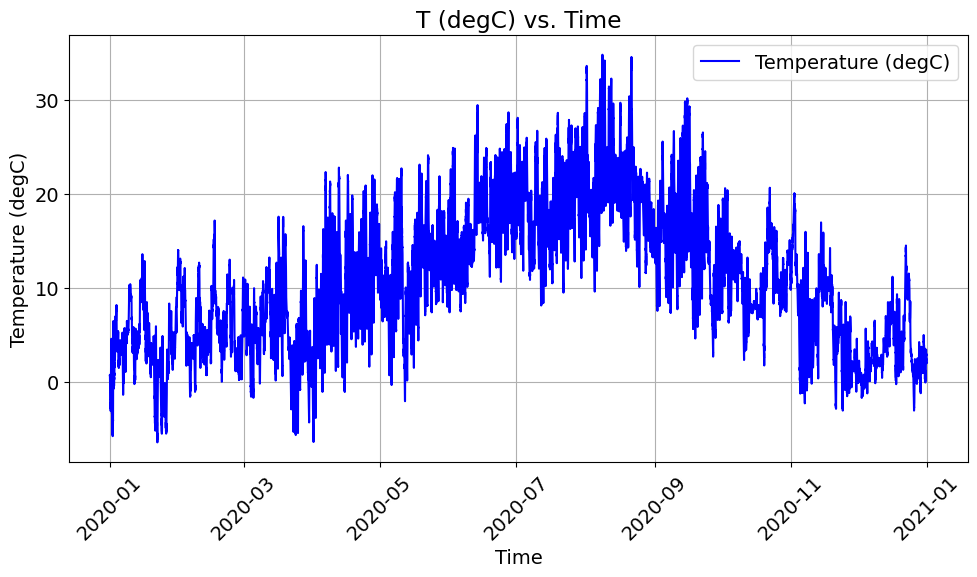

In [ ]:
# Plot T(degC) vs. Time
date_strs = np.genfromtxt(
    'weather.csv',
    delimiter=",",
    skip_header=1,
    usecols=0,
    dtype=str
)

# Convert date strings to datetime objects
timesteps = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in date_strs]

# Extract the temperature column
temperatures = data[:, 2].numpy()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(timesteps, temperatures, label='Temperature (degC)', color='blue')
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Temperature (degC)')
plt.title('T (degC) vs. Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Convert dates and times to numbers
times = torch.tensor(
    [datetime.strptime(date, '%Y-%m-%d %H:%M:%S').timestamp() for date in date_strs],
    dtype=torch.float
).unsqueeze(1)
data[:, 0] = times[:, 0]/ 1e+9

# Split into testing and training datasets
x = data[:, [i for i in range(data.shape[1]) if i != 2]]
y = data[:, 2]

train_len = int(0.7*len(data))

train_indices = list(range(train_len))
test_indices = list(range(train_len, len(data)))

train_dataset = TensorDataset(x[train_indices], y[train_indices])
test_dataset = TensorDataset(x[test_indices], y[test_indices])

batch_size = 10000
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Task 2

In [ ]:
class DLinear(nn.Module):
    def __init__(self, A_s, A_r):
        super(DLinear, self).__init__()
        self.A_s = nn.Parameter(A_s)
        self.A_r = nn.Parameter(A_r)

    def forward(self, T, S):
        return self.A_s @ S + self.A_r @ T

In [ ]:
A_s = torch.randn(1, 21, device=device) * 0.01
A_r = torch.randn(1, 21, device=device) * 0.01

model = DLinear(A_s, A_r)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
compute_loss = nn.MSELoss()

In [ ]:
num_epochs = 100
model.train()

for epoch in range(num_epochs):
    train_loss = 0
    for inputs, targets in train_loader:
        trend = inputs.mean(dim=0)
        seasonal = inputs - trend
        for i in range(inputs.shape[0]):
            output = model(trend, seasonal[i])
            loss = compute_loss(output.squeeze(), targets[i])
            train_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss/ len(train_dataset):.4f}')

Epoch [10/100], Loss: 2.3382
Epoch [20/100], Loss: 2.8942
Epoch [30/100], Loss: 2.5721
Epoch [40/100], Loss: 2.3063
Epoch [50/100], Loss: 2.0263
Epoch [60/100], Loss: 1.7778
Epoch [70/100], Loss: 1.6331
Epoch [80/100], Loss: 1.5225
Epoch [90/100], Loss: 1.4260
Epoch [100/100], Loss: 1.3466


In [ ]:
# Testing
model.eval()
predictions = []
y = []
with torch.no_grad():
    total_loss = 0
    for inputs, targets in test_loader:
        trend = inputs.mean(dim=0)
        seasonal = inputs - trend
        for i in range(inputs.shape[0]):
            output = model(trend, seasonal[i])
            loss = compute_loss(output.squeeze(), targets[i])
            total_loss += loss.item()

            predictions.append(output.item())
            y.append(targets[i].item())

    print(f'Test Loss: {total_loss / len(test_dataset):.4f}')

Test Loss: 1.5881


In [ ]:
def plot_compare_prediction(predictions, y):
    num_samples = len(predictions)
    time = timesteps[-num_samples:]
    plt.figure(figsize=(10, 6))
    plt.plot(time, y, label='Actual')
    plt.plot(time, predictions, label='Predicted')
    plt.xticks(rotation=45)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.title('Model Predictions vs Actual Values')
    plt.show()

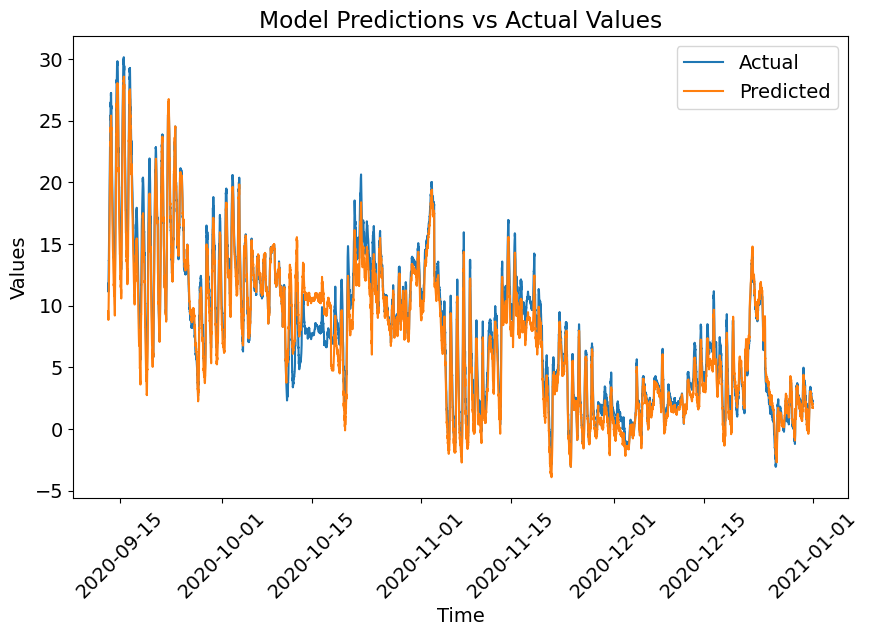

In [ ]:
predictions = np.array(predictions)
y = np.array(y)
plot_compare_prediction(predictions, y)